In [2]:
#pip install -q -U keras-tuner

In [1]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img
import keras_tuner as kt
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.preprocessing import image

%matplotlib inline

## Preprocessing

In [3]:
train_dir = 'D:/documents/GitHub/Radios_COVID19/COVID-19_Radiography_Dataset'

normal_imgs = [fn for fn in os.listdir(f'{train_dir}/Normal/images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{train_dir}/COVID/images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{train_dir}/Viral Pneumonia/images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{train_dir}/Lung_Opacity/images') if fn.endswith('.png')]

In [4]:
#Randomly select X of each images
random_sample = 400

select_norm = np.random.choice(normal_imgs, random_sample, replace = False)
select_covid = np.random.choice(covid_imgs, random_sample, replace = False)
select_pneumonia = np.random.choice(pneumonia_imgs, random_sample, replace = False)
select_lung_opacity = np.random.choice(lung_opacity_imgs, random_sample, replace = False)

In [5]:
liste = []

for fn in select_norm :
    liste.append(f'{train_dir}/Normal/images/' + fn)
for fn in select_covid :
    liste.append(f'{train_dir}/COVID/images/' + fn)
for fn in select_pneumonia :
    liste.append(f'{train_dir}/Viral Pneumonia/images/' + fn)
for fn in select_lung_opacity :
    liste.append(f'{train_dir}/Lung_Opacity/images/' + fn)

liste = list(map(lambda x : [x, x.split('/')[5]], liste))

In [6]:
#Créer un DataFrame pandas
df = pd.DataFrame(liste, columns = ['filepath', 'nameLabel'])
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))]).astype(str)

print('DataFrame size : ', df.shape)
print(df['nameLabel'].value_counts())
df.head()

DataFrame size :  (1600, 3)
Normal             400
COVID              400
Viral Pneumonia    400
Lung_Opacity       400
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
1,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
2,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
3,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0
4,D:/documents/GitHub/Radios_COVID19/COVID-19_Ra...,Normal,0


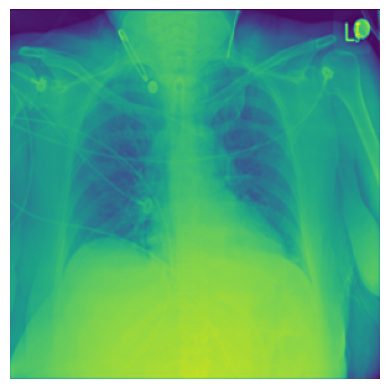

In [7]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [8]:
size = 256 #Image size (depending on model definition)
ratio_val = 0.2 #percentage of dataset to be held into test
batch_size = 210

train_data_generator = ImageDataGenerator( )
test_data_generator = ImageDataGenerator( )

# Création des itérateurs qui chargeront des lots d'images
train, test = train_test_split(df, test_size = ratio_val)

print(f"Number of rows in train set: {len(train)}")

train_generator = train_data_generator.flow_from_dataframe(dataframe = train,
                                                           x_col="filepath",
                                                           y_col="label",
                                                           class_mode = "sparse",
                                                           target_size = (size,size),
                                                           batch_size = batch_size,
                                                           color_mode = "grayscale")

print(f"Number of rows in test set: {len(test)}")
test_generator = test_data_generator.flow_from_dataframe(dataframe = test,
                                                         x_col="filepath",
                                                         y_col="label",
                                                         class_mode = "sparse",
                                                         target_size = (size,size),
                                                         batch_size = batch_size,
                                                         color_mode = "grayscale",
                                                         shuffle=False) 


Number of rows in train set: 1280
Found 1280 validated image filenames belonging to 4 classes.
Number of rows in test set: 320
Found 320 validated image filenames belonging to 4 classes.


## LeNet Model

In [9]:
def model_builder(hp) :
    model = Sequential()
 
    model.add(Conv2D(filters = 30 , kernel_size = (5,5), input_shape =[256,256,1], activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Conv2D(filters = 16, kernel_size = (3,3), activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2,2)))

    model.add(Flatten())
    model.add(Dropout(rate = 0.2))

    model.add(Dense(units = 128, activation = "relu"))
    model.add(Dense(units = 4, activation = "softmax"))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate), 
                  metrics = ["accuracy"])
    
    return model

## Entrainement Modèle

In [11]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 10,
                     factor = 3)

stop_early = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 5)

train_size = train_generator.samples
test_size = test_generator.samples

epochs_turner = 20

tuner.search(train_generator,
             epochs = epochs_turner,
             steps_per_epoch = train_size // batch_size,
             validation_data = test_generator,
             validation_steps = test_size // batch_size,
             callbacks = [stop_early])


INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [12]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.get('learning_rate'))

0.0001


In [27]:
# Build the model with the optimal hyperparameters and train it on the data for 20 epochs
model = tuner.hypermodel.build(best_hps)

epochs = 20

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_size,
                    validation_data = test_generator,
                    validation_steps = test_size // batch_size)

Epoch 1/20
6/6 [==============================] - 94s 16s/step - loss: 88.3040 - accuracy: 0.2563 - val_loss: 57.0888 - val_accuracy: 0.2619
Epoch 2/20
6/6 [==============================] - 36s 6s/step - loss: 32.2835 - accuracy: 0.2944 - val_loss: 6.5445 - val_accuracy: 0.5000
Epoch 3/20
6/6 [==============================] - 27s 4s/step - loss: 4.9067 - accuracy: 0.3611 - val_loss: 1.8184 - val_accuracy: 0.4619
Epoch 4/20
6/6 [==============================] - 25s 4s/step - loss: 1.5889 - accuracy: 0.4476 - val_loss: 1.2403 - val_accuracy: 0.4667
Epoch 5/20
6/6 [==============================] - 22s 4s/step - loss: 1.2004 - accuracy: 0.4944 - val_loss: 1.1823 - val_accuracy: 0.4571
Epoch 6/20
6/6 [==============================] - 22s 3s/step - loss: 1.1944 - accuracy: 0.4860 - val_loss: 1.1868 - val_accuracy: 0.4619
Epoch 7/20
6/6 [==============================] - 21s 3s/step - loss: 1.1694 - accuracy: 0.4804 - val_loss: 1.1330 - val_accuracy: 0.4667
Epoch 8/20
6/6 [==============

In [28]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 2


In [ ]:
#Réinstanciez l'hypermodèle et entraînez-le avec le nombre optimal d'époques d'en haut.

hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(img_train, label_train, epochs=best_epoch, validation_split=0.2)

In [ ]:
#Evaluation du hypermodel (best epochs and best learning rate)

eval_result = hypermodel.evaluate(img_test, label_test)
print("[test loss, test accuracy]:", eval_result)

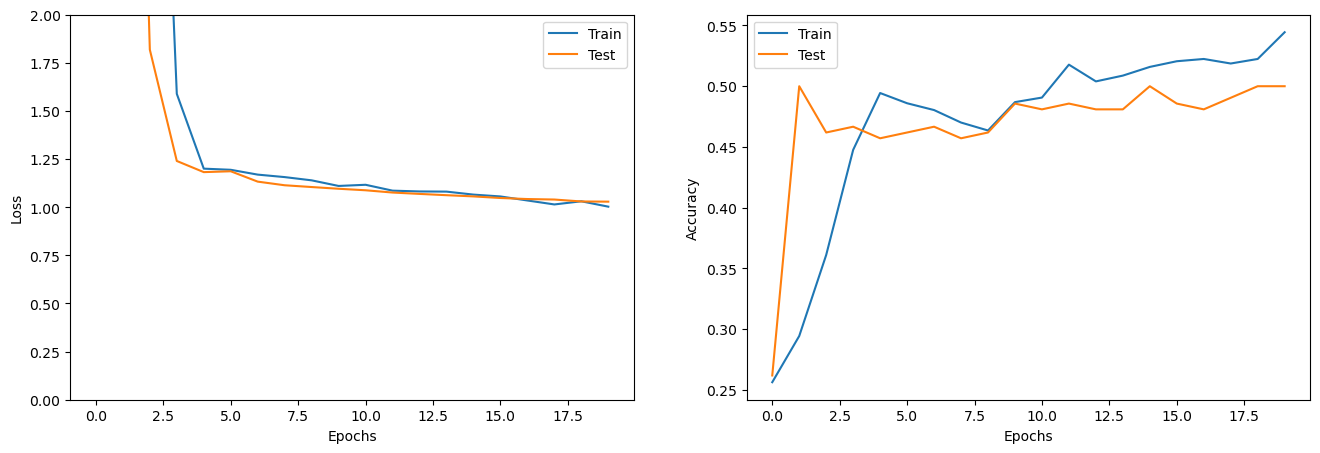

In [29]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

plt.subplot(121)
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance 

In [30]:
# Prédictions (probabilités)
test_generator.reset()
test_pred_lenet = model.predict(test_generator, verbose = 1 )

2/2 [==============================] - 8s 612ms/step


In [31]:
# Récupération des classes à partir des probabilités
test_pred_lenet_class = test_pred_lenet.argmax(axis = 1)

# Matrice de confusion
print(confusion_matrix(test_generator.classes, test_pred_lenet_class))

[[16  0 13 50]
 [29  0  4 43]
 [ 1  0 73  3]
 [ 7  0  1 80]]


In [32]:
print(classification_report(test_generator.classes, test_pred_lenet_class, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.30      0.20      0.24        79
           1       0.00      0.00      0.00        76
           2       0.80      0.95      0.87        77
           3       0.45      0.91      0.61        88

    accuracy                           0.53       320
   macro avg       0.39      0.51      0.43       320
weighted avg       0.39      0.53      0.44       320



C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
